In [1]:
# images are on vehicles/ and non-vehicles/ folders
# get the list of car images and non-car images and put them in the list
# also write those lists in *.txt files.
import os
import glob
import random
# get the list of image files from vehicles/ directory
def get_images(arr,img_dir, name):
    image_dir = img_dir
    image_folders = os.listdir(image_dir)
    for folder in image_folders:
        arr.extend(glob.glob(image_dir+folder+'/*'))
    print('Number of ' + name + ' Images found: ', len(arr))
    img_filename = name + '.txt'
    with open(img_filename, 'w') as f:
        for fn in arr:
            f.write(fn+'\n')
      
    return arr

# get vehicle image list
cars = []
img_dir = 'vehicles/'
cars = get_images(cars, img_dir, 'cars')

# get non-vehicle image list
notcars = []
img_dir = 'non-vehicles/'
noncars = get_images(notcars, img_dir, 'noncars')

#shuffling cars and noncars
random.shuffle(cars)
random.shuffle(noncars)

Number of cars Images found:  8792
Number of noncars Images found:  8968


In [2]:
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

In [3]:
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # make sure to do this order spatial_feat, hist_feat, hog_feat.
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            #hist_features=((np.array(hist_features))/(max(hist_features))).astype('float32')
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy



In [61]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True,vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True)) 
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=vis, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=vis, feature_vec=True)
                
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

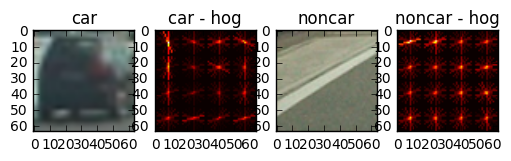

In [78]:
# test features using one random car image and one random noncar image.
# try hog feature
%matplotlib inline

# car_ind and noncar_ind are random indices
car_ind = np.random.randint(0, len(cars))
noncar_ind = np.random.randint(0, len(noncars))

# read in one car and one non-car random images
car_image = mpimg.imread(cars[car_ind])
noncar_image = mpimg.imread(noncars[noncar_ind])

# define feature parameters
color_space = 'YCrCb' # can be RGB, HSV, etc.
orient = 9
#pix_per_cell = 8
pix_per_cell = 16
cell_per_block = 2
hog_channel = 2 # can be 0, 1, 2, or 'ALL'
spatial_size = (16, 16)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

car_features, car_hog_image= single_img_features(car_image,color_space=color_space,
                                                 spatial_size=spatial_size,hist_bins=hist_bins,
                                                 orient=orient,pix_per_cell=pix_per_cell,
                                                 cell_per_block=cell_per_block,
                                                 hog_channel=hog_channel,spatial_feat=spatial_feat,
                                                 hist_feat=hist_feat,hog_feat=hog_feat,vis=True)

notcar_features, noncar_hog_image= single_img_features(noncar_image,color_space=color_space,
                                                 spatial_size=spatial_size,hist_bins=hist_bins,
                                                 orient=orient,pix_per_cell=pix_per_cell,
                                                 cell_per_block=cell_per_block,
                                                 hog_channel=hog_channel,spatial_feat=spatial_feat,
                                                 hist_feat=hist_feat,hog_feat=hog_feat,vis=True)

#f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 2, figsize=(20,10))
plt.subplot( 1, 4, 1 )
plt.imshow(car_image, cmap='hot')
plt.title( "car")
plt.imsave('output_images/car_image_example.jpg', car_image)
plt.subplot( 1, 4, 2 )
plt.imshow(car_hog_image, cmap='hot')
plt.title( "car - hog")
plt.imsave('output_images/noncar_image_example.jpg', noncar_image)
plt.subplot( 1, 4, 3 )
plt.imshow(noncar_image, cmap='hot')
plt.title( "noncar")
plt.imsave('output_images/car_hog_image_example.jpg', car_hog_image)
plt.subplot( 1, 4, 4 )
plt.imshow(noncar_hog_image, cmap='hot')
plt.title( "noncar - hog")
plt.imsave('output_images/noncar_hog_image_example.jpg', noncar_hog_image)

In [88]:
# test classify and train
# For test, reduce the sample size because HOG features are slow to compute
sample_size = 3000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#colorspace = 'RGB'
orient = 9
pix_per_cell = 8
#pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)
#spatial_size = (32, 32)
hist_bins = 16
spatial_feat = True
hist_feat = True
hog_feat = True

t=time.time()

car_features = extract_features(cars,color_space=color_space,
                                                 spatial_size=spatial_size,hist_bins=hist_bins,
                                                 orient=orient,pix_per_cell=pix_per_cell,
                                                 cell_per_block=cell_per_block,
                                                 hog_channel=hog_channel,spatial_feat=spatial_feat,
                                                 hist_feat=hist_feat,hog_feat=hog_feat)

notcar_features = extract_features(notcars,color_space=color_space,
                                                 spatial_size=spatial_size,hist_bins=hist_bins,
                                                 orient=orient,pix_per_cell=pix_per_cell,
                                                 cell_per_block=cell_per_block,
                                                 hog_channel=hog_channel,spatial_feat=spatial_feat,
                                                 hist_feat=hist_feat,hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

92.3 Seconds to extract features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
2.34 Seconds to train SVC...
Test Accuracy of SVC =  0.9875
My SVC predicts:  [ 1.  1.  1.  1.  1.  1.  0.  0.  0.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  1.  0.  0.  0.  1.]
0.00348 Seconds to predict 10 labels with SVC


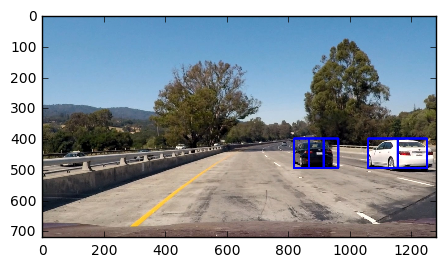

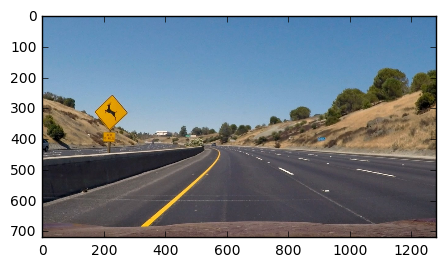

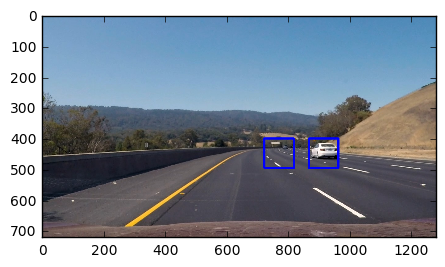

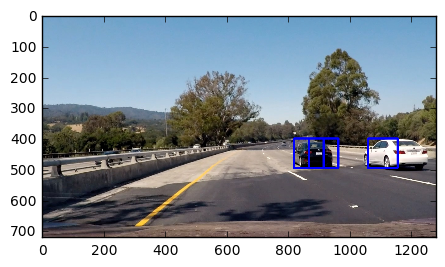

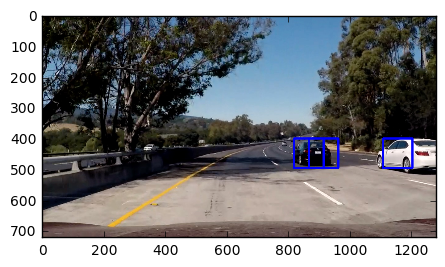

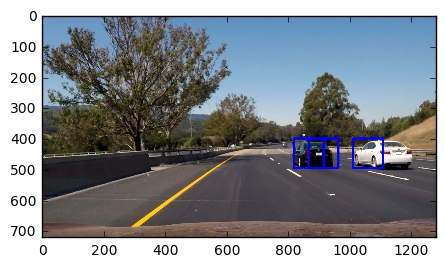

In [89]:
%matplotlib inline

# sliding window test using one test jpt file
y_start_stop = [400, 656]
xy_overlap = (0.5, 0.5)
xy_window=(96, 96)

searchpath = 'test_images/*'
example_images = glob.glob(searchpath)

i = 1
for src_img in example_images:
    image = mpimg.imread(src_img)
    
#image = mpimg.imread('test_images/test1.jpg')
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255


    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=xy_window, xy_overlap=xy_overlap)

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    fig = plt.figure(figsize = (15,20))
    plt.subplot(6, 1, i)
    plt.imshow(window_img)
    i = i + 1

In [90]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)


In [111]:
from scipy.ndimage.measurements import label

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1]+1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return img


In [104]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    heatmap = np.zeros_like(img[:,:,0])
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64

    nblocks_per_window = (window // pix_per_cell)-1 

    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
              
    return draw_img, heatmap

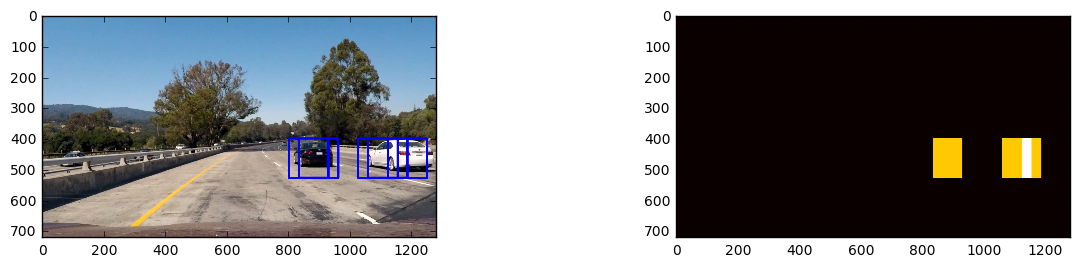

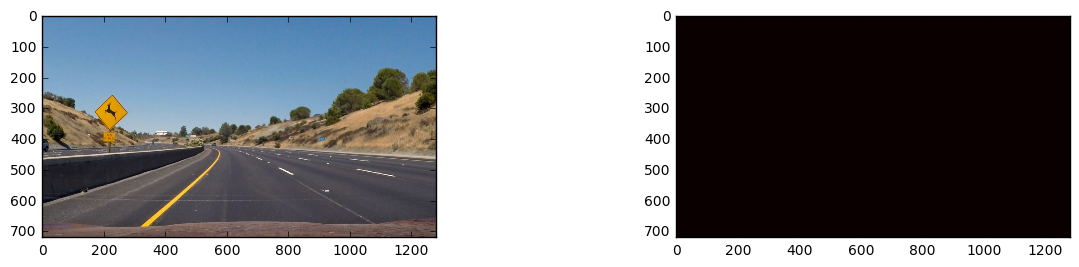

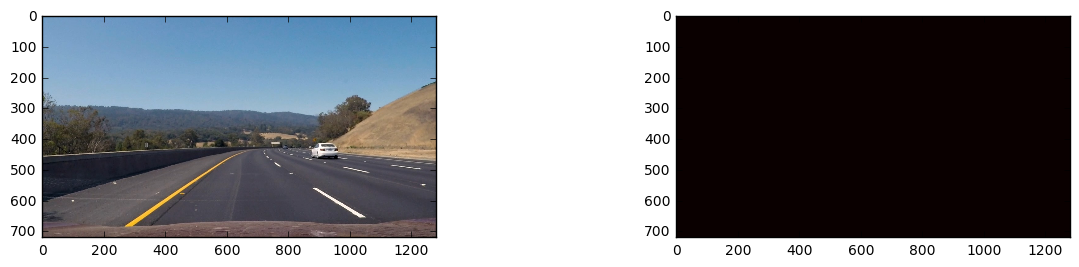

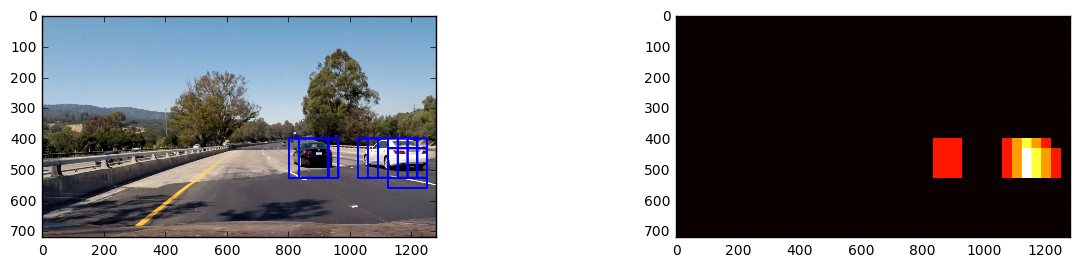

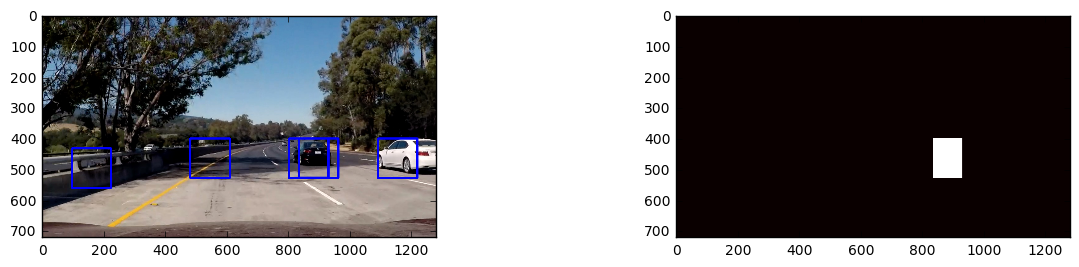

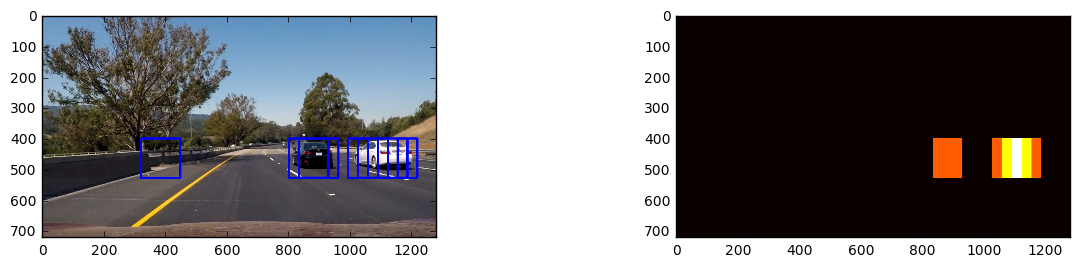

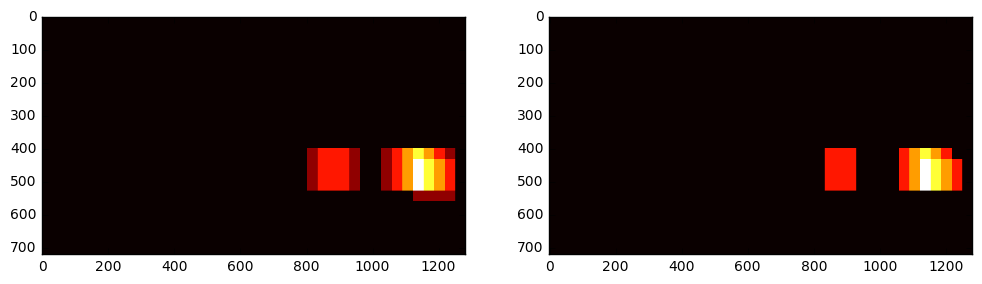

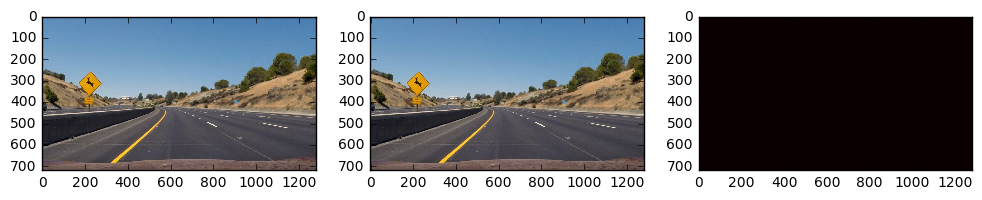

In [127]:
ystart = 400
ystop = 656
scale = 2
#scale = 1
j = 1
i = 1
for src_img in example_images:
    img = mpimg.imread(src_img)    
    out_img, heatmap = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heatmap = apply_threshold(heatmap,1)
    labels = label(heatmap)
    #draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    draw_img = draw_labeled_bboxes(np.copy(out_img), labels)
    fig = plt.figure(figsize = (15,20))
    plt.subplot(6, 2, j)
    plt.imshow(draw_img)
    plt.subplot(6, 2, j+1)
    plt.imshow(heatmap, cmap='hot')
    draw_txt = "output_images/car_image_with_boxes" + str(i) + ".jpg"
    plt.imsave(draw_txt, draw_img)
    heat_txt = "output_images/heat_image" + str(i) + ".jpg"
    plt.imsave(heat_txt, heatmap)
    j = j + 2
    i = i + 1
# test 
img = mpimg.imread('test_images/test4.jpg')
  
out_img, heatmap = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
fig = plt.figure(figsize = (12,18))
plt.subplot(1, 2, 1)
plt.imshow(heatmap, cmap='hot')
heat_txt_1 = "output_images/heat_image_before.jpg"
plt.imsave(heat_txt_1, heatmap)
heatmap = apply_threshold(heatmap,1)
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(out_img), labels)
plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='hot')
heat_txt_2 = "output_images/heat_image_after.jpg"
plt.imsave(heat_txt_2, heatmap)
# test 
img = mpimg.imread('test_images/test2.jpg')
  
out_img, heatmap = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
fig = plt.figure(figsize = (12,18))
plt.subplot(1, 3, 1)
plt.imshow(out_img)
heatmap = apply_threshold(heatmap,1)
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(out_img), labels)
plt.subplot(1, 3, 2)
plt.imshow(draw_img)
plt.subplot(1, 3, 3)
plt.imshow(heatmap, cmap='hot')

In [96]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [125]:
def process_image(img_read):
    image = img_read
    out_img, heat_map = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat_map = apply_threshold(heat_map,1)
    labels = label(heat_map)
    draw_img = draw_labeled_bboxes(np.copy(out_img), labels)
    return draw_img

In [126]:
test_output = "project_output.mp4"
clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(process_image)
test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [06:34<00:00,  3.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 



In [ ]:
#test_output = "test_output.mp4"
#clip = VideoFileClip("test_video.mp4")
#test_clip = clip.fl_image(process_image)
#test_clip.write_videofile(test_output, audio=False)